In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [5]:
def month_map(month_str):
    """Map month abbreviations to their corresponding numerical values."""
    months = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
        'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
        'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }
    return months.get(month_str, None)

In [6]:
new_df = pd.read_csv(r'G:\learn\python_works\google_ee\rudra\datas\attatchments\discharge_data_from_internet.csv')
new_df['Month'] = new_df['Month'].map(month_map)
new_df = new_df.rename(columns={'Discharge (m3/s)': 'Discharge'})

df = pd.read_csv('bias_corrected_discharge_with_trend.csv', usecols=['Year', 'Month', 'another_Bias_Corrected_Discharge'])
df = df.rename(columns={'another_Bias_Corrected_Discharge': 'Discharge'})

In [7]:
import pandas as pd
import numpy as np

# --- Load and prepare both datasets ---
new_df = pd.read_csv(r'G:\learn\python_works\google_ee\rudra\datas\attatchments\discharge_data_from_internet.csv')
new_df['Month'] = new_df['Month'].map(month_map)
new_df = new_df.rename(columns={'Discharge (m3/s)': 'Discharge'})

df = pd.read_csv('bias_corrected_discharge_with_trend.csv', usecols=['Year', 'Month', 'another_Bias_Corrected_Discharge'])
df = df.rename(columns={'another_Bias_Corrected_Discharge': 'Discharge'})

# --- Combine for trend visualization ---
all_data = pd.concat([new_df, df], ignore_index=True)
all_data['Date'] = pd.to_datetime(all_data['Year'].astype(str) + '-' + all_data['Month'].astype(str) + '-01')
all_data.sort_values('Date', inplace=True)

# --- Fit a polynomial model on yearly average discharge from 1963–1977 and 2006–2100 ---
# Calculate annual average
observed = new_df.groupby('Year')['Discharge'].mean()
modeled = df.groupby('Year')['Discharge'].mean()

# Combine for regression
combined_years = pd.concat([observed, modeled])
X = combined_years.index.values.reshape(-1, 1)
y = combined_years.values

# Fit 2nd degree polynomial (adjust if needed)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
reg = LinearRegression()
reg.fit(X_poly, y)

# Predict discharge for missing years (1978–2005)
missing_years = np.arange(1978, 2006)
X_missing = missing_years.reshape(-1, 1)
X_missing_poly = poly.transform(X_missing)
y_missing = reg.predict(X_missing_poly)

# Expand to monthly values by copying seasonal pattern from observed data
monthly_pattern = new_df.groupby('Month')['Discharge'].mean()

# Build interpolated dataframe
filled_data = []
for i, year in enumerate(missing_years):
    for month in range(1, 13):
        # Scale the monthly pattern to match predicted annual average
        seasonal_ratio = monthly_pattern[month] / monthly_pattern.mean()
        estimated_monthly = y_missing[i] * seasonal_ratio
        filled_data.append([year, month, estimated_monthly])

gap_df = pd.DataFrame(filled_data, columns=['Year', 'Month', 'Discharge'])

# --- Final Combined Dataset ---
final_df = pd.concat([new_df, gap_df, df], ignore_index=True)
final_df.sort_values(['Year', 'Month'], inplace=True)


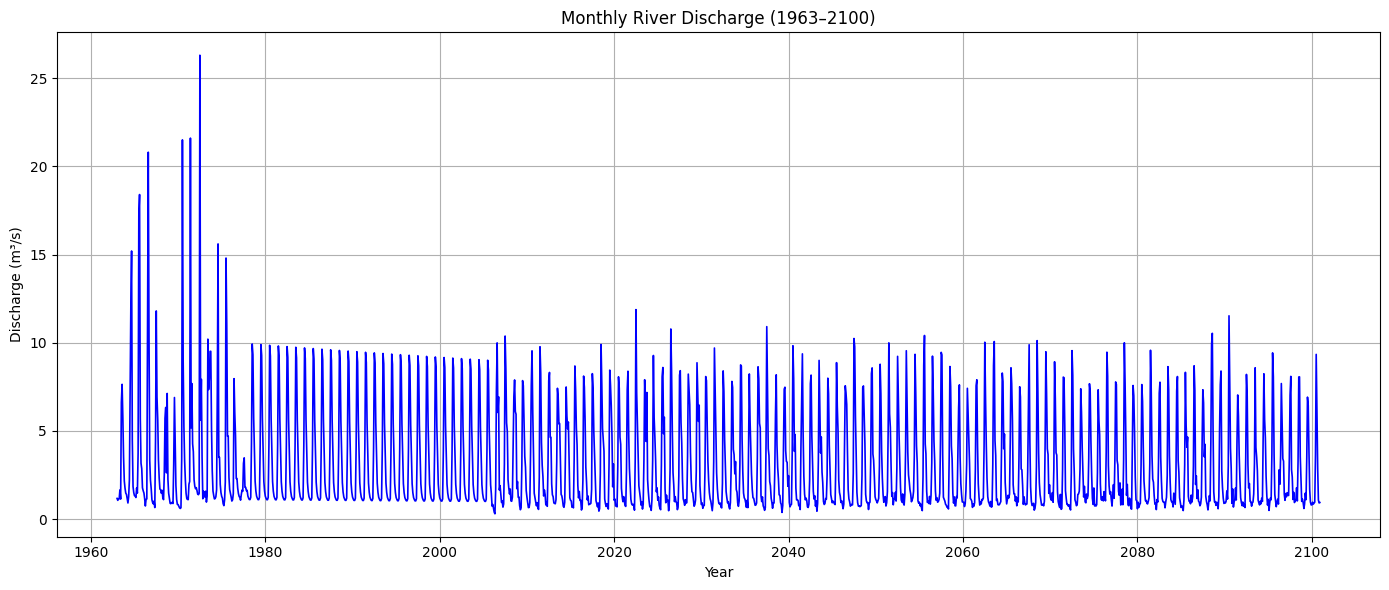

In [8]:
import matplotlib.pyplot as plt

# Create a datetime column for plotting
final_df['Date'] = pd.to_datetime(final_df['Year'].astype(str) + '-' + final_df['Month'].astype(str) + '-01')

# Sort by date just to be sure
final_df = final_df.sort_values('Date')

# Plot
plt.figure(figsize=(14, 6))
plt.plot(final_df['Date'], final_df['Discharge'], color='blue', linewidth=1.2)
plt.title('Monthly River Discharge (1963–2100)')
plt.xlabel('Year')
plt.ylabel('Discharge (m³/s)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
final_df.to_csv('final_discharge_1963_2100.csv', index=False)
